# Implementación de Bagging

En este Notebook llevaremos acabo un ejemplo de implementación de Bagging, para facilitar el entendimiento del funcionamiento de los modelos. 

Se utilizará como modelo base el `DecisionTreeRegressor` de Sci-Kit Learn para el problema de Predicción de Precios de Viviendas en Boston. 

En este notebook usted irá implementando paso a paso los elementos que componen el algoritmo. 



<table class="tfo-notebook-buttons" align="center">

  <td>
    <a target="_blank" href="https://colab.research.google.com/github/juancop/metodos_analitica_2/blob/main/03_ensambles/02_bagging_boosting/02_bagging.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/juancop/metodos_analitica_2/blob/03_ensambles/02_bagging_boosting/02_bagging.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
  
</table>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
import pandas as pd
import numpy as np

## Carga de Datos

Utilizaremos los Datasets de Sci-Kit Learn para cargar la información de precios de vivienda.

In [4]:
boston_housing = load_boston()

In [5]:
boston_housing.keys() # Elementos con los que vienen los datos

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

Estos datos vienen como arrays de NumPy y sin nombres de campos. A cotninuación los convertiremos en DataFrames y asignaremos los nombres a nuestras variables explicativas.

In [6]:
X = pd.DataFrame(boston_housing['data'], columns = boston_housing['feature_names'])
y = pd.DataFrame(boston_housing['target'])

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [8]:
y.head()

,0
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


## Pre-Procesamiento de Datos

A continuación dividiremos la información en Train y Test, y realizaremos un escalamiento de datos.

Para la división en train-test, utilice la función de [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [13]:
### Utilice train_test_split para dividir los datos en entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
###

In [14]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
116,0.13158,0.0,10.01,0.0,0.547,6.176,72.5,2.7301,6.0,432.0,17.8,393.30,12.04
45,0.17142,0.0,6.91,0.0,0.448,5.682,33.8,5.1004,3.0,233.0,17.9,396.90,10.21
16,1.05393,0.0,8.14,0.0,0.538,5.935,29.3,4.4986,4.0,307.0,21.0,386.85,6.58
468,15.57570,0.0,18.10,0.0,0.580,5.926,71.0,2.9084,24.0,666.0,20.2,368.74,18.13


Se sugiere realizar un MinMax scaler como procesamiento inicial de las features. Usted puede probar con otros procesamientos. 

Para esto, utilice [`sklearn.preprocessing.MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). 

In [15]:
###

scaler = StandardScaler()
scaler.fit(X_train)
X_train.values[:] = scaler.transform(X_train)
X_test.values[:] = scaler.transform(X_test)

###

In [16]:
X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
5,-0.414259,-0.505125,-1.292142,-0.281546,-0.851085,0.145264,-0.365584,1.081628,-0.746179,-1.112790,0.187271,0.396514,-1.015316
116,-0.402008,-0.505125,-0.162083,-0.281546,-0.087967,-0.208401,0.133941,-0.487876,-0.398464,0.150088,-0.212090,0.387067,-0.053663
45,-0.397211,-0.505125,-0.609489,-0.281546,-0.936828,-0.896237,-1.266900,0.628596,-0.746179,-1.046639,-0.167716,0.428541,-0.311324
16,-0.290936,-0.505125,-0.431970,-0.281546,-0.165136,-0.543965,-1.429789,0.345133,-0.630274,-0.601625,1.207859,0.312760,-0.822422
468,1.457816,-0.505125,1.005500,-0.281546,0.194987,-0.556496,0.079645,-0.403892,1.687825,1.557294,0.852872,0.104124,0.803800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-0.397237,-0.505125,-0.371354,-0.281546,-0.319475,-0.681810,0.836171,-0.732385,-0.514369,-0.138570,1.163486,0.414371,0.878423
270,-0.381828,0.380752,-0.602272,-0.281546,-0.799639,-0.653963,-0.966462,0.312349,-0.746179,-1.106776,0.142897,0.333497,0.081504
348,-0.416046,3.038382,-1.316677,-0.281546,-1.048295,0.430702,-1.415310,2.156415,-0.630274,-0.763995,-0.567077,0.359879,-0.905493
435,0.926113,-0.505125,1.005500,-0.281546,1.566884,0.422348,0.933904,-0.773035,1.687825,1.557294,0.852872,-2.878413,1.527504


Con el procesamiento anterior, es posible comenzar a programar los modelos que vamos a utilizar.

# Implementación de Bagging

Recordemos que Bagging consiste de tres elementos: 
- Muestreo aleatorio con reemplazamiento de los datos de entrenamiento (muestras bootstrap)

- Entrenamiento del mismo modelo en cada una de las diferentes $B$ muestras, 
$$\Big\{\hat{f}_b(x) \Big\}_{b = 1, \dots, B}$$

- Combinación de predicciones a través de un promedio simple, 

$$\hat{f}_{bagging} (x) = \frac{1}{B} \sum_{b = 1}^B \hat{f}_b(x)$$

Vamos a crear una clase que nos permita estimar un conjunto de árboles de regresión ($\hat{f}_b(x)$) y lo utilizaremos para predecir. 

## 1. Boostrap Sampling

El primer elemento de la función es quizás el más importante del *Bagging*, pues corresponde al muestreo aleatorio con reemplazamiento. 


Utilice el métoo de [`pd.DataFrame.sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) para tomar una muestra aleatoria con reemplazamiento **de las filas**.

In [30]:
def _sample_features(self, X, y, random_state = None):
  """
  Generación de [una] muestra Bootstrap para entrenar un modelo de árbol de regresión.

  Params
  --------
    X (pandas.DataFrame):
      Un dataframe que contiene los features de entrenamiento

    y (pandas.DataFrame):
      Un dataframe que contiene el target para el entrenamiento

    random_state (int):
      [Default None] Valor de semilla. Utilizar únicamente para pruebas.


  Returns
  --------
    sampled_x (pandas.DataFrame):
      Un dataframe que contiene una muestra bootstrap de los datos originales

    sampled_y (pandas.DataFrame):
      Un dataframe que contiene una la variable dependiente de cada observación.
  """
  ###

  sampled_x = X.sample(replace = True, frac = 1, axis = 0, random_state = random_state)
  sampled_y = y.loc[sampled_x.index] # Asigne a cada X su Y.

  ###

  return sampled_x, sampled_y

Si la función fue programada correctamente, entonces el resultado de la siguiente celda debería ser:

|         |         0 |
|:--------|----------:|
| CRIM    | -22.3237  |
| ZN      |  -3.87571 |
| INDUS   |  -6.34016 |
| CHAS    |  -3.83336 |
| NOX     | -35.7036  |
| RM      | -21.231   |
| AGE     | -46.6513  |
| DIS     |  22.7396  |
| RAD     | -21.3265  |
| TAX     | -32.3898  |
| PTRATIO |  37.1405  |
| B       | -10.3039  |
| LSTAT   |  10.5585  |

In [38]:
X_sampled_fn, y_sampled_fn = _sample_features(None, X_train, y_train, random_state = 42)
X_sampled_fn.sum()

CRIM      -22.323733
ZN         -3.875711
INDUS      -6.340163
CHAS       -3.833361
NOX       -35.703620
RM        -21.231019
AGE       -46.651271
DIS        22.739562
RAD       -21.326511
TAX       -32.389809
PTRATIO    37.140536
B         -10.303920
LSTAT      10.558478
dtype: float64

## Entrenamiento de un Árbol

La idea de Bagging es entrenar el mismo modelo en diferentes muestras de la base de entrenamiento original. Por esto, deberemos crear una función que genere la muestra *Bootstrap* y entrene el árbol de regresión en esta. 

Utilice [`sklearn.tree.DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.predict) para su estimador base (su weak learner).


In [40]:
def train_single_tree(self, X, y):
  """
  Entrena un árbol de regresión en una muestra bootstrap de los datos originales.

   Params
  --------
    X (pandas.DataFrame):
      Un dataframe que contiene los features de entrenamiento

    y (pandas.DataFrame):
      Un dataframe que contiene el target para el entrenamiento

  Returns
  --------
    tree (sklearn.tree.DecisionTreeRegressor):
      Un modelo de árbol de regresión ajustado en una muestra 
      bootstrap de los datos de entrenamiento.

  """
  ###

  # 1. Utilice la función _sample_features para generar una muestra
  sampled_X, sampled_y = self._sample_features(X, y) 

  # 2. Entrene el modelo de regresión. Fije el parámetro max_features = self.col_prop
  tree = DecisionTreeRegressor(max_features = self.col_prop)

  # 3. Utilice el método .fit() para ajustar el modelo
  tree.fit(sampled_X, sampled_y)

  ###
  return tree

## Todo Junto

En la siguiente celda se tiene el código que nos permitirá entrenar en paralelo un número arbitrario de árboles. Esta clase utilizará las funciones definidas anteriormente. 

La función que se paraleliza es `train_single_tree` y la función de predicción `predict_multiple`.

In [41]:
class BaggingRegressor:

  def __init__(self, n_trees = 200, col_prop = 0.6, n_jobs = 3):
    self.n_trees = n_trees
    self.col_prop = col_prop
  
    self.n_jobs = n_jobs

    self.model_list = None
    self.X = None
    self.y = None


  def parallel_fit_training(self, X, y):
    """
    Realiza un entrenamiento en paralelo de la cantidad de árboles especiicados en self.n_trees
    """
    self.model_list = Parallel(n_jobs=self.n_jobs, 
                               timeout=99999)(delayed(self.train_single_tree)(X, y) for _ in tqdm(range(self.n_trees)))


  def predict_multiple(self, X):
    """
    Realiza la predicción de cada elemento del ensamble. 

    Params
    -------
      X (pd.DataFrame):
        DataFrame que cotiene los features para predecir

    Returns
    -------
      prediction_array (numpy.array):
        Un array que contiene todas las predicciones de cada 
        elemento del ensamble.

    """

    prediction_list = Parallel(n_jobs=self.n_jobs, timeout=99999)(delayed(model.predict)((X[model.feature_names_in_])) for model in tqdm(self.model_list))
    prediction_array = np.array(prediction_list)
    return prediction_array

  def predict(self, X, reduce = True):
    """
    Método para realizar las predicciones. 

    Params
    --------
      X (pd.DataFrame):
        DataFrame que cotiene los features para predecir
      
      reduce (bool):
        [Default True] Indica si se desea que la predicción sea el promedio del 
        ensamble. Si reduce = False, entonces se devuelve la predicción
        de cada modelo individual.
    """
    prediction = self.predict_multiple(X)

    if reduce:
      return prediction.mean(axis = 0)
    else:
      return prediction.T

  def fit(self, X, y):
    """
    Ajusta el modelo.

    Params
    --------
      X (pd.DataFrame):
        Datos de entrenamiento (features)
      y (pd.DataFrame):
        Target para los datos de entrenamiento

    """
    self.parallel_fit_training(X, y)

En esta clase añadimos los métodos que creamos anteriormente.

In [42]:
BaggingRegressor._sample_features = _sample_features

In [43]:
BaggingRegressor.train_single_tree = train_single_tree

## Bagging Default & Random Forest

Como se habló en clase, el Random Forest es un modelo de Bagging, que busca disminuir la correlación entre los modelos al restringir las features a las que tiene acceso cada split. De esta forma, los árboles entrenados son diferentes unos de otros. 

Si en nuestro `BaggingRegressor` especificamos un `col_prop = 1`, estaremos entrenado un modelo Bagging estándar (default). Si `col_prop < 1`, se estará entrenando un `Random Forest`. 

A continuación, entrene un modelo Bagging con `col_prop = 1` y otro con `col_prop < 1`. Ambos modelos deben tener `n_trees = 1000`. 

In [47]:
### Entrenamiento de BaggingEnsemble

BaggingEnsemble = BaggingRegressor(n_trees = 1000, col_prop = 1)
BaggingEnsemble.fit(X_train, y_train)

###

100%|██████████| 1000/1000 [00:05<00:00, 190.55it/s]


In [48]:
### Entrenamiento de Random Forest

RandomForest = BaggingRegressor(n_trees = 1000) # el col prop es un hiperparámetro que toca tunear
RandomForest.fit(X_train, y_train)

###


100%|██████████| 1000/1000 [00:06<00:00, 156.10it/s]


## Desempeño del Modelo



## Evolución del Modelo

Anteriormente observamos cómo el `RandomForest` tuvo un mejor desempeño que el `BaggingEnsemble`. 

En esta sección revisaremos cómo evolucionan las métricas de desempeño del modelo a medida que se incluyen más `weak_learners` y si tienen algo que ver con la diferencia de los resultados de evaluación.


Realizaremos las predicciones nuevamente, pero esta vez se fijará el parámetro `reduce = False`. De esta forma, no obtendremos una predicción final, sino las predicciones que hicieron cada uno de los 1000 árboles. 

In [49]:
### Predicciones de Bagging Ensemble

y_pred_test_bag =  BaggingEnsemble.predict(X_test, reduce = False)

###

100%|██████████| 1000/1000 [00:03<00:00, 318.38it/s]


In [50]:
### Predicciones en Random Forest

y_pred_test_rf =  RandomForest.predict(X_test, reduce = False)

###

100%|██████████| 1000/1000 [00:03<00:00, 312.53it/s]


Una vez tenemos las predicciones, queremos ver cómo nos hubiera dado el error del modelo si únicamente hubieramos utilizado los primeros `m` árboles. 

In [51]:
def mse_first_m_models(y_true, predictions, m):
  """
  Calcula el MSE de cada modelo utilizando únicamente las primeras m predicciones.
  """

  ### 
  # 1. Seleccione las primeras m predicciones y calcule el promedio
  mth_avg_pred = predictions[:, :m].mean(axis = 1)

  # 2. Calcule el MSE
  mse = mean_squared_error(y_true, mth_avg_pred)

  ###
  return mse

In [62]:
n_trees = np.arange(1, 1000)

In [63]:
mse_list_rf = [mse_first_m_models(y_test, y_pred_test_rf, m) for m in n_trees]
mse_list_bag = [mse_first_m_models(y_test, y_pred_test_bag, m) for m in n_trees]

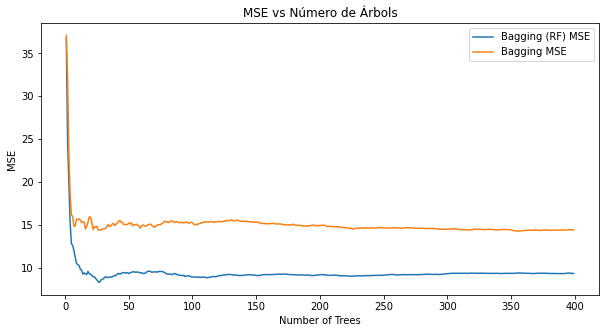

In [61]:
plt.figure(figsize = (10, 5))
plt.plot(n_trees, mse_list_rf, label = 'Bagging (RF) MSE')
plt.plot(n_trees, mse_list_bag, label = 'Bagging MSE')
plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('MSE')
plt.title('MSE vs Número de Árboles')
plt.show()

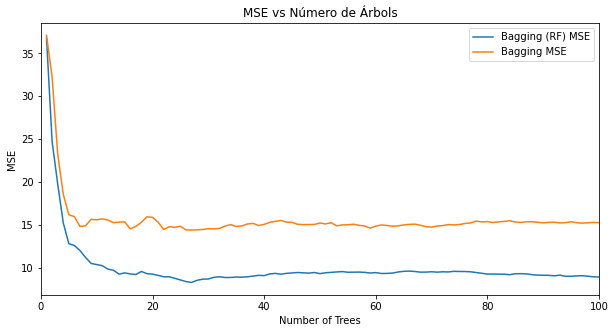

In [64]:
plt.figure(figsize = (10, 5))
plt.plot(n_trees, mse_list_rf, label = 'Bagging (RF) MSE')
plt.plot(n_trees, mse_list_bag, label = 'Bagging MSE')
plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('MSE')
plt.title('MSE vs Número de Árboles')
plt.xlim(0, 100)
plt.show()